# **Assignment 9**
# **Coronal dimmings on the Solar Limb**

### **Data Analysis for Space Weather | Instructor: Prof Podladchikova | April, 2021**
### **by Victoria Krivova, Polina Starodumova**

In [1]:
# importing necessary libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import math
import numpy as np
from PIL import Image
import scipy
import sunpy
import sunpy.map
from astropy.io import fits
from astropy import units as u
from scipy import stats

**Background:** Coronal dimmings are regions in the solar corona that abruptly undergo a drastic decrease of emission, as observed in the extreme ultraviolet (EUV) or soft X-rays (SXR). The reduced emission is interpreted as a density depletion caused by the evacuation and expansion of coronal plasma due to the coronal mass ejection (CME) eruption. CMEs are huge structures of magnetized plasma ejected from the Sun and the major source of severe space weather disturbances on Earth.

**Data for the analysis:**  STEREO/EUVI filtergrams of the 195 Å passband with a cadence of 5 minutes for 5 events, where coronal dimmings and their associated CMEs with different speeds and masses were observed off-limb.

In [ ]:
# load the folders with 6 dimming events 
import zipfile as zf
files = zf.ZipFile("files.zip", 'r')
files.extractall('Ass9_data')
files.close()

Let's start with analysis of 20100807_1725 as it has simple evolution.

**7 August 2010 event**

In [2]:
# In the original Astropy package of units, there is no angstrom, however, it will be needed for FITS files to work 
# correctly, so we deifine the unit by ourselves
ANG = u.def_unit('ANG', 10**(-10) * u.m)
u.add_enabled_units([ANG]);

In [3]:
files = [sunpy.io.fits.read('Ass9_data/20100807_1725/20100807_1725_0%02d_195.fits' % i)[0] for i in range(31)]
data = [files[i].data for i in range(31)]
header = [files[i].header for i in range(31)]

dates = []
for i in range(31):
    dates.append(pd.to_datetime(header[i]['DATE-OBS'], format=' %d-%b-%Y %H:%M:%S.%f')) 
    
#dates[0]

Now we define the solar disk area and extract it from the images - we will work only with the off-limb emission.

In [4]:
resol = header[0]['CDELT1'] # arcsec/pix
arcsec_sun = header[0]['RSUN'] # solar radius, arcsec
r_sun = arcsec_sun / resol # in pixels

# coordinates of Sun's center in pixels
x0 = header[0]['CRPIX1']
y0 = header[0]['CRPIX2']

In [5]:
# shape of images
x_len = data[0].shape[1]
y_len = data[0].shape[0]

In [6]:
off_limb = np.empty(shape=[31, y_len, x_len]) # array of off-limb emissions

for i in range(31): # files of event
    for k in range(y_len):
        for j in range(x_len):
            r = math.sqrt((j - x0)**2 + (k - y0)**2)
            if r > r_sun:
                off_limb[i][k][j] = data[i][k][j]
            else:
                off_limb[i][k][j] = None

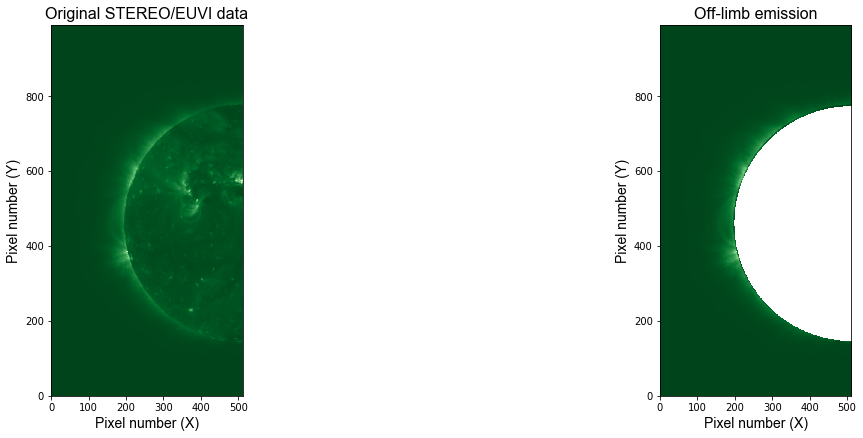

In [7]:
axis_font = {'fontname':'Arial', 'size':'14'}
title_font = {'fontname':'Arial', 'size':'16'} 

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data[20], cmap='Greens_r')
ax1.invert_yaxis()
ax1.set_title('Original STEREO/EUVI data', **title_font)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(off_limb[20], cmap='Greens_r')
ax2.invert_yaxis()
ax2.set_title('Off-limb emission', **title_font);

Let's create base-difference (BD) and  logarithmic baseratio (LBR) sequences of images, using the first pre-event image as a base:   


In [8]:
i_0 = off_limb[0]

In [9]:
bd = np.empty(shape=[31, y_len, x_len])

for i in range(1, 31):
    bd[i] = off_limb[i] - i_0    
    
lbr = np.empty(shape=[31, y_len, x_len])

for i in range(1, 31):
    lbr[i] = np.log(off_limb[i]) - np.log(i_0)

/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


**Errors arise while calculating logarithm of zero pixels of off-limb mask, we'll skip it – obtained LBR pixels will have NaN value (grey areas in the pic):**

Text(0.5, 1.0, 'LBR')

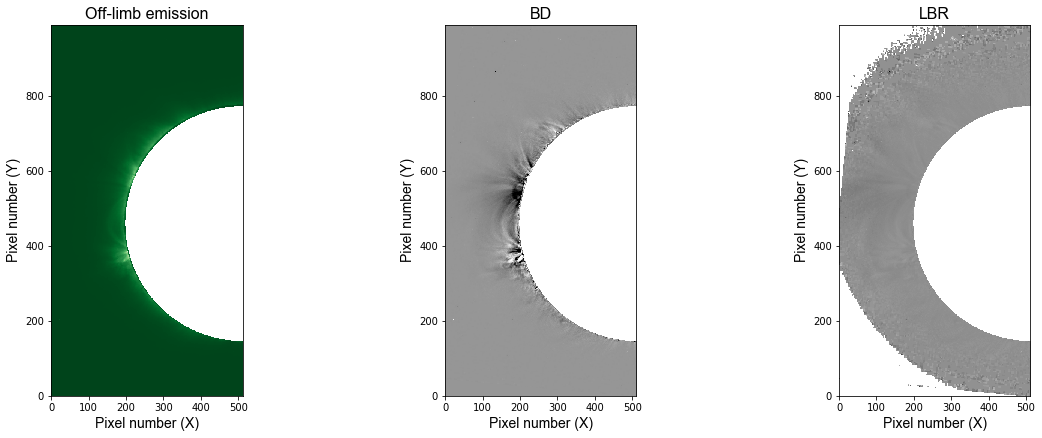

In [10]:
fig = plt.figure(figsize=(20, 15))

ax3 = fig.add_subplot(2,3,1)
ax3.set_xlabel('Pixel number (X)', **axis_font)
ax3.set_ylabel('Pixel number (Y)',  **axis_font)
ax3.imshow(off_limb[30], cmap='Greens_r')
ax3.invert_yaxis()
ax3.set_title('Off-limb emission', **title_font);

ax2 = fig.add_subplot(2,3,2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(bd[30], cmap='Greys_r', norm=colors.Normalize(vmin=-100, vmax=100))
ax2.invert_yaxis()
ax2.set_title('BD', **title_font);

ax1 = fig.add_subplot(2,3,3)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(lbr[30], cmap='Greys_r')
ax1.invert_yaxis()
ax1.set_title('LBR', **title_font)

**Let's plot the distribution of BD and LBR intensity forthe first and the last maps for the off-limb area. Dimmings represent pixels with low intensity, therefore, for the last image there is a shift in pixels to the negative values.** "First map" here is the second image in dataset as calculating BD/LBR makes no sense for the first one.

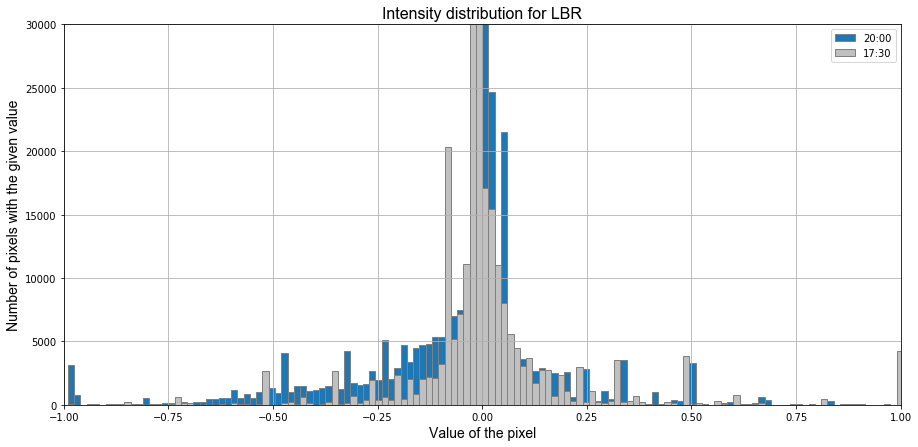

In [11]:
fig = plt.figure(figsize=(15,7))

# so that histograms have equal widths of bin
bin_size = 0.015; min_edge = -1.5; max_edge = 1.5
N = int((max_edge-min_edge) / bin_size)
Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

plt.hist(lbr[30][np.isfinite(lbr[30])], bin_list, ec='gray') # here we drop NaNs and inf values as it is void areas

plt.hist(lbr[1][np.isfinite(lbr[1])], bin_list, color='silver', ec='gray')

plt.xlabel("Value of the pixel", **axis_font)
plt.ylabel("Number of pixels with the given value", **axis_font)
plt.xlim(-1, 1)
plt.ylim(0, 30000)
plt.title("Intensity distribution for LBR", **title_font)
plt.legend(['20:00', '17:30'])
plt.grid();

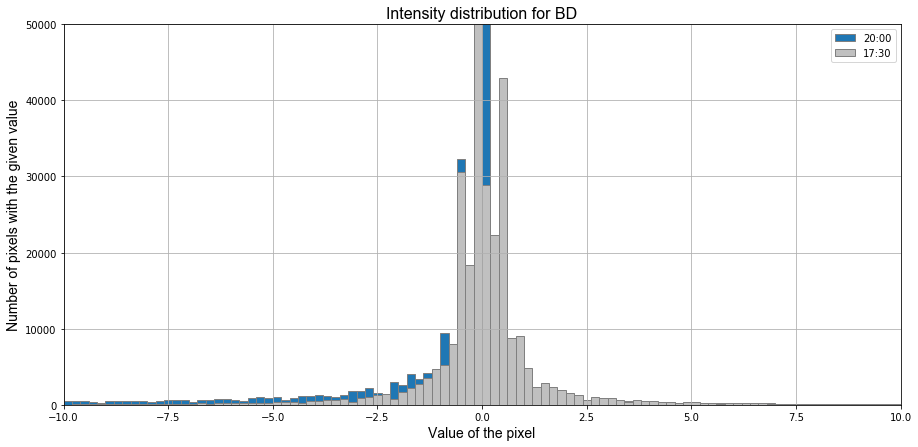

In [12]:
fig = plt.figure(figsize=(15,7))

bin_size = 0.2
min_edge = -50; max_edge = 50
N = int((max_edge-min_edge) / bin_size)
Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

plt.hist(bd[30][np.isfinite(bd[30])], bin_list, ec='gray')

plt.hist(bd[1][np.isfinite(bd[1])], bin_list, color='silver', ec='gray')

plt.xlabel("Value of the pixel", **axis_font)
plt.ylabel("Number of pixels with the given value", **axis_font)
plt.xlim(-10, 10)
plt.ylim(0, 50000)
plt.title("Intensity distribution for BD", **title_font)
plt.legend(['20:00', '17:30'])
plt.grid();

**Using the histogram, we'll define the level of thresholding *level_diff* to extract the dimming from BD images and find the level *level_ratio* for LBR data (manually by counting bins with defined width):**

In [13]:
level_diff = -2
level_ratio = -0.11

**Next applying thresholding to the BD and LBR sequences of images:**

In [14]:
bd_thres = np.empty(shape=[31, y_len, x_len])

for i in range(1, 31): 
    for k in range(y_len):
        for j in range(x_len):
            cell = bd[i][k][j]
            if np.isfinite(cell):
                if cell < level_diff:
                    bd_thres[i][k][j] = cell
                else:
                    bd_thres[i][k][j] = None
            else:
                bd_thres[i][k][j] = None

In [15]:
lbr_thres = np.empty(shape=[31, y_len, x_len])

for i in range(1, 31): 
    for k in range(y_len):
        for j in range(x_len):
            cell = lbr[i][k][j]
            if np.isfinite(cell):
                if cell < level_ratio:
                    lbr_thres[i][k][j] = cell
                else:
                    lbr_thres[i][k][j] = None
            else:
                lbr_thres[i][k][j] = None

**Plotting the original STEREO/EUVI data, thresholded BD and LBR data for the last image:**

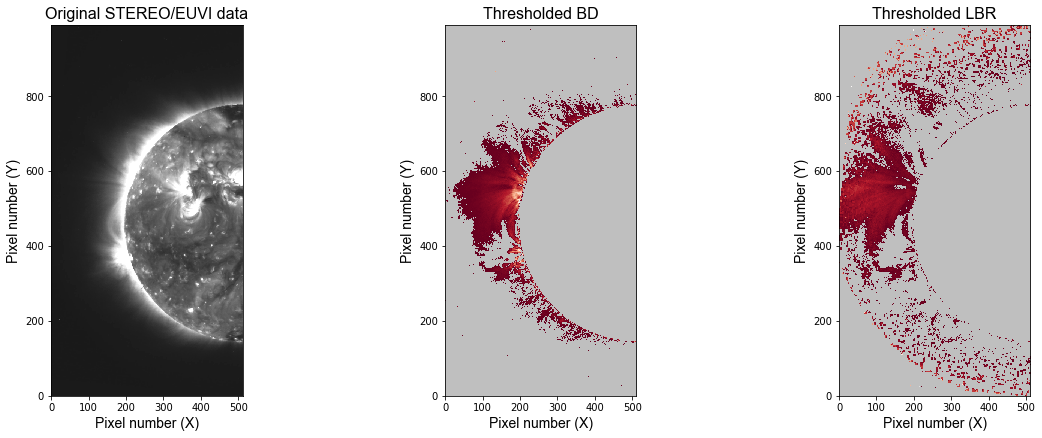

In [16]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,3,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(data[30], cmap='Greys_r', norm=colors.Normalize(vmin=-30, vmax=300))
ax1.invert_yaxis()
ax1.set_title('Original STEREO/EUVI data', **title_font)

ax3 = fig.add_subplot(2,3,2)
ax3.set_xlabel('Pixel number (X)', **axis_font)
ax3.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.RdGy_r
cmap.set_bad('grey', 0.5)
ax3.imshow(bd_thres[30], cmap=cmap) # empty areas are now in grey
ax3.invert_yaxis()
ax3.set_title('Thresholded BD', **title_font);

ax2 = fig.add_subplot(2,3,3)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.RdGy_r
cmap.set_bad('grey', 0.5)
ax2.imshow(lbr_thres[30], cmap=cmap) 
ax2.invert_yaxis()
ax2.set_title('Thresholded LBR', **title_font);

**We do both processing as corona density decreases with height, low corona has higher emission, so in absolute values we might not detect the changes. Ratio allows to equally consider different regions.** 

**As we can see LBR is noisy in the upper corona, BD – in the lower one, thus to reduce noise let's calculate final dimming mask which will be determined as overlapping of BD and LBR thresholding masks:**

In [17]:
dimming = np.empty(shape=[31, y_len, x_len])

for i in range(1, 31): 
    for k in range(y_len):
        for j in range(x_len):
            cell_1 = bd_thres[i][k][j]
            cell_2 = lbr_thres[i][k][j]
            if (np.isfinite(cell_1) and np.isfinite(cell_2)):
                dimming[i][k][j] = cell_1 * cell_2
            else:
                dimming[i][k][j] = None

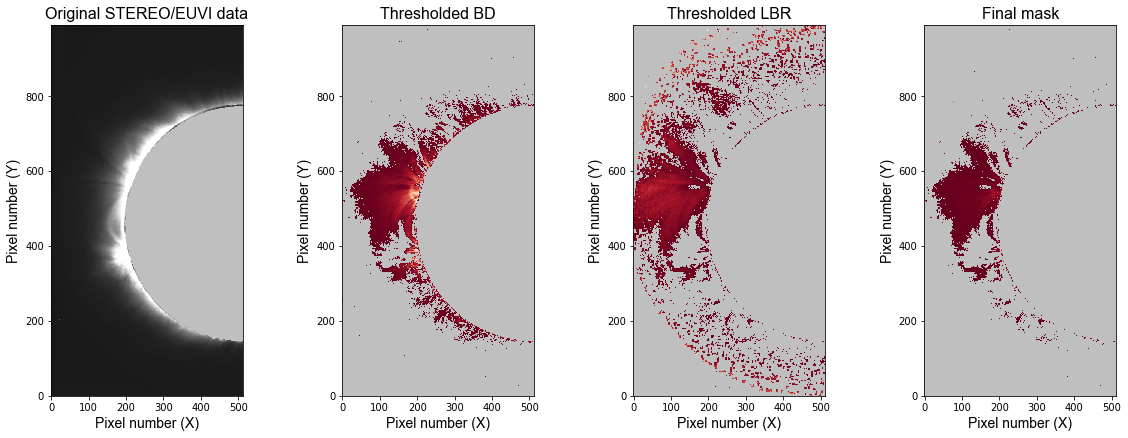

In [18]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,4,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.Greys_r
cmap.set_bad('grey', 0.5)
ax1.imshow(off_limb[30], cmap=cmap, norm=colors.Normalize(vmin=-30, vmax=300))
ax1.invert_yaxis()
ax1.set_title('Original STEREO/EUVI data', **title_font)

ax3 = fig.add_subplot(2,4,2)
ax3.set_xlabel('Pixel number (X)', **axis_font)
ax3.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.RdGy_r
cmap.set_bad('grey', 0.5)
ax3.imshow(bd_thres[30], cmap=cmap) # empty areas are now in grey
ax3.invert_yaxis()
ax3.set_title('Thresholded BD', **title_font);

ax2 = fig.add_subplot(2,4,3)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.RdGy_r
cmap.set_bad('grey', 0.5)
ax2.imshow(lbr_thres[30], cmap=cmap) 
ax2.invert_yaxis()
ax2.set_title('Thresholded LBR', **title_font);

ax4 = fig.add_subplot(2,4,4)
ax4.set_xlabel('Pixel number (X)', **axis_font)
ax4.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.RdGy
cmap.set_bad('grey', 0.5)
ax4.imshow(dimming[30], cmap=cmap) 
ax4.invert_yaxis()
ax4.set_title('Final mask', **title_font);

**We also apply median filtering to the final mask of dimmimg to reduce noise:**

In [19]:
dim_filt = []
dim_filt.append(np.empty(shape=[y_len, x_len]))

for i in range(1, 31):
    dim_filt.append(scipy.ndimage.median_filter(dimming[i], size=9, mode='reflect'))

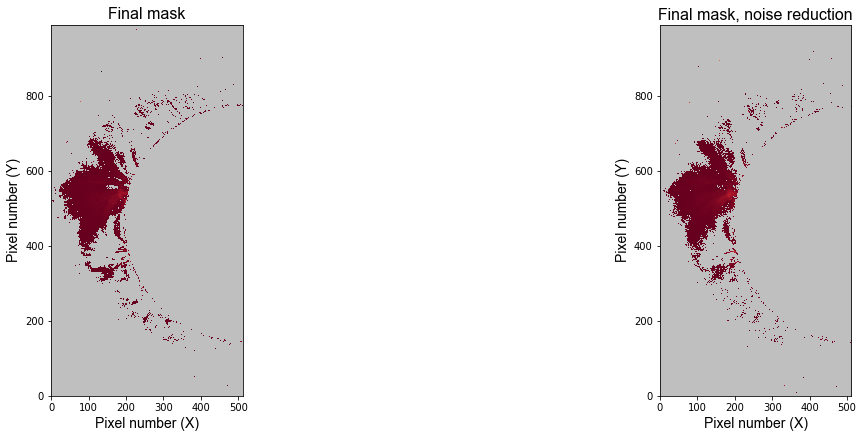

In [20]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.RdGy
cmap.set_bad('grey', 0.5)
ax1.imshow(dimming[30], cmap=cmap) 
ax1.invert_yaxis()
ax1.set_title('Final mask', **title_font);

ax4 = fig.add_subplot(2,2,2)
ax4.set_xlabel('Pixel number (X)', **axis_font)
ax4.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.RdGy
cmap.set_bad('grey', 0.5)
ax4.imshow(dim_filt[25], cmap=cmap) 
ax4.invert_yaxis()
ax4.set_title('Final mask, noise reduction', **title_font);

**Let's define the area of the dimming in km^2 as the number of pixels in the dimming mask for each time step:**

In [21]:
# calculate the number of dimming pixels

dim_num = np.zeros(31)

for i in range(1, 31): 
    for k in range(y_len):
        for j in range(x_len):
            if np.isfinite(dim_filt[i][k][j]):
                dim_num[i] += 1

In [22]:
# the angular resolution per pixel scale
resol = header[12]['CDELT1'] # arcsec/pix
arcsec_sun = header[12]['RSUN'] # radius of Sun in arcseconds

R_sun = 696340 # km
km_per_arcsec = R_sun / arcsec_sun     

area_unit = (resol * km_per_arcsec) ** 2 # km^2

In [23]:
# array of dimming areas

dim_area = np.empty(31)

for i in range(1, 31): 
    dim_area[i] = dim_num[i] * area_unit

**Next we define the brightness of the dimming as a sum of pixel intensities within the dimming mask (using intensity from base difference data, as it shows the absolute darkening of the pixels).**

In [24]:
dim_bright = np.zeros(31)

for i in range(1, 31): 
    for k in range(y_len):
        for j in range(x_len):
            if np.isfinite(dim_filt[i][k][j]) and np.isfinite(bd[i][k][j]):
                dim_bright[i] += bd[i][k][j]

**Plotting area and brightnessas a function of time:**

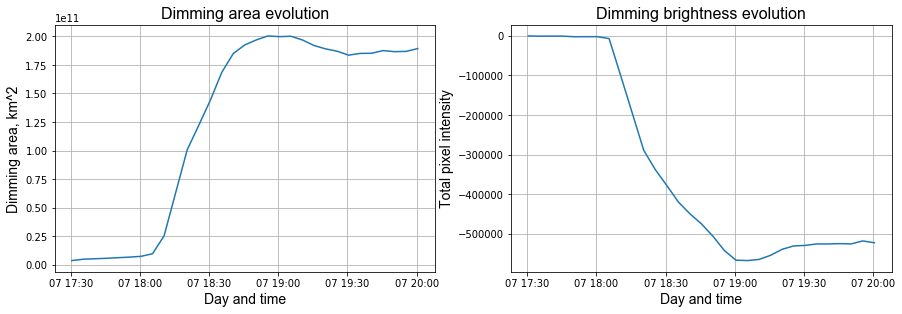

In [25]:
fig = plt.figure(figsize=(15, 10))

ax2 = fig.add_subplot(2,2,1)
plt.plot(pd.to_datetime(dates)[1:], dim_area[1:])
ax2.set_xlabel('Day and time', **axis_font)
ax2.set_ylabel('Dimming area, km^2', **axis_font)
ax2.set_title('Dimming area evolution', **title_font)
ax2.grid()

ax1 = fig.add_subplot(2,2,2)
plt.plot(pd.to_datetime(dates)[1:], dim_bright[1:])
ax1.set_xlabel('Day and time', **axis_font)
ax1.set_ylabel('Total pixel intensity', **axis_font)
ax1.set_title('Dimming brightness evolution', **title_font)
ax1.grid()

**Dimming area values start at zero point, then experience distinct growth and reach maximum, after that they are likely to gradually decrease, and the cumulative area will come to the plateau. What is noticable, the intensity decreases rapidly when the dimming area expands (around 18:10 for this event). So, the bigger – the darker for the growth phase, and then – while the area decreases, intensity increases approximately at the same rate (slowly).** 

**From the dimming pixel mask sequence, let's create a mask that contains all pixels that have been identified as dimming pixels over the whole observation interval - total dimming pixel mask.**

In [26]:
total_dim = np.empty([y_len, x_len])

for i in range(1, 31): 
    for k in range(y_len):
        for j in range(x_len):
            if np.isfinite(dim_filt[i][k][j]):
                total_dim[k][j] = 1
            

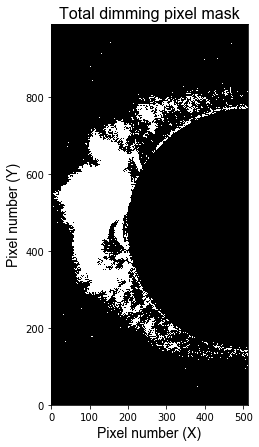

In [27]:
fig, ax1 = plt.subplots(figsize=(5, 7))

ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
cmap = matplotlib.cm.Greys_r
ax1.imshow(total_dim, cmap=cmap) 
ax1.invert_yaxis()
ax1.set_title('Total dimming pixel mask', **title_font);

**Calculating the total dimming area and converting it to km^2:**

In [28]:
total_area = 0
for k in range(y_len):
    for j in range(x_len):
        if total_dim[k][j] == 1:
            total_area += area_unit

In [29]:
print(total_area)

343973179516.63916


**Now we repeat all the steps for other events (except changing thresholding level, we use the same for each dataset), obtaining the value of total dimming area. Plots below are made for the last image of event.**

In [36]:
# arrays of areas 

a_arr = []
a_arr.append(total_area) # from calculations above

In [37]:
def dim_analysis(data_files, header, num_files): # implements all the steps above
    dates = []
    for i in range(num_files):
        dates.append(pd.to_datetime(header[i]['DATE-OBS'], format='%d-%b-%Y %H:%M:%S.%f'))
    x_len = data_files[0].shape[1]
    y_len = data_files[0].shape[0]
    
    off_limb = np.empty(shape=[num_files, y_len, x_len]) 
    for i in range(num_files): 
        for k in range(y_len):
            for j in range(x_len):
                r = math.sqrt((j - x0)**2 + (k - y0)**2)
                if r > r_sun:
                    off_limb[i][k][j] = data_files[i][k][j]
                else:
                    off_limb[i][k][j] = None
                    
    bd = np.empty(shape=[num_files, y_len, x_len])
    for i in range(1, num_files):
        bd[i] = off_limb[i] - off_limb[0]    

    lbr = np.empty(shape=[num_files, y_len, x_len])
    for i in range(1, num_files):
        lbr[i] = np.log(off_limb[i]) - np.log(off_limb[0])
        
    bd_thres = np.empty(shape=[num_files, y_len, x_len])
    for i in range(1, num_files): 
        for k in range(y_len):
            for j in range(x_len):
                cell = bd[i][k][j]
                if np.isfinite(cell):
                    if cell < level_diff:
                        bd_thres[i][k][j] = cell
                    else:
                        bd_thres[i][k][j] = None
                else:
                    bd_thres[i][k][j] = None

    lbr_thres = np.empty(shape=[num_files, y_len, x_len])
    for i in range(1, num_files): 
        for k in range(y_len):
            for j in range(x_len):
                cell = lbr[i][k][j]
                if np.isfinite(cell):
                    if cell < level_ratio:
                        lbr_thres[i][k][j] = cell
                    else:
                        lbr_thres[i][k][j] = None
                else:
                    lbr_thres[i][k][j] = None     
                    
    dimming = np.empty(shape=[num_files, y_len, x_len])
    for i in range(1, num_files): 
        for k in range(y_len):
            for j in range(x_len):
                cell_1 = bd_thres[i][k][j]
                cell_2 = lbr_thres[i][k][j]
                if (np.isfinite(cell_1) and np.isfinite(cell_2)):
                    dimming[i][k][j] = cell_1 * cell_2
                else:
                    dimming[i][k][j] = None
                    
    dim_filt = np.empty(shape=[num_files, y_len, x_len])
    for i in range(1, num_files):
        dim_filt[i] = scipy.ndimage.median_filter(dimming[i], size=9, mode='reflect')
                    
    dim_bright = np.zeros(num_files)
    for i in range(1, num_files): 
        for k in range(y_len):
            for j in range(x_len):
                if np.isfinite(dim_filt[i][k][j]) and np.isfinite(bd[i][k][j]):
                    dim_bright[i] += bd[i][k][j]
                    
    total_dim = np.empty([y_len, x_len])
    for i in range(1, num_files): 
        for k in range(y_len):
            for j in range(x_len):
                if np.isfinite(dim_filt[i][k][j]):
                    total_dim[k][j] = 1
                    
    total_area = 0
    for k in range(y_len):
        for j in range(x_len):
            if total_dim[k][j] == 1:
                total_area += area_unit
                
    dim_num = np.zeros(num_files)
    for i in range(1, num_files): 
        for k in range(y_len):
            for j in range(x_len):
                if np.isfinite(dim_filt[i][k][j]):
                    dim_num[i] += 1
    dim_area = np.empty(num_files)
    for i in range(1, num_files): 
        dim_area[i] = dim_num[i] * area_unit
                
    
    fig = plt.figure(figsize=(15, 10))
    ax2 = fig.add_subplot(2,2,1)
    plt.plot(pd.to_datetime(dates)[1:], dim_area[1:])
    ax2.set_xlabel('Day and time', **axis_font)
    ax2.set_ylabel('Dimming area, km^2', **axis_font)
    ax2.set_title('Dimming area evolution', **title_font)
    ax2.grid()
    ax1 = fig.add_subplot(2,2,2)
    plt.plot(pd.to_datetime(dates)[1:], dim_bright[1:])
    ax1.set_xlabel('Day and time', **axis_font)
    ax1.set_ylabel('Total pixel intensity', **axis_font)
    ax1.set_title('Dimming brightness evolution', **title_font)
    ax1.grid()
    
    fig = plt.figure(figsize=(20, 15))

    ax1 = fig.add_subplot(2,4,1)
    ax1.set_xlabel('Pixel number (X)', **axis_font)
    ax1.set_ylabel('Pixel number (Y)',  **axis_font)
    cmap = matplotlib.cm.RdGy_r
    cmap.set_bad('grey', 0.5)
    ax1.imshow(bd_thres[num_files-1], cmap=cmap)
    ax1.invert_yaxis()
    ax1.set_title('Thresholded BD', **title_font)

    ax3 = fig.add_subplot(2,4,2)
    ax3.set_xlabel('Pixel number (X)', **axis_font)
    ax3.set_ylabel('Pixel number (Y)',  **axis_font)
    cmap = matplotlib.cm.RdGy_r
    cmap.set_bad('grey', 0.5)
    ax3.imshow(lbr_thres[num_files-1], cmap=cmap) # empty areas are now in grey
    ax3.invert_yaxis()
    ax3.set_title('Thresholded LBR', **title_font);

    ax2 = fig.add_subplot(2,4,3)
    ax2.set_xlabel('Pixel number (X)', **axis_font)
    ax2.set_ylabel('Pixel number (Y)',  **axis_font)
    cmap = matplotlib.cm.RdGy
    cmap.set_bad('grey', 0.5)
    ax2.imshow(dim_filt[num_files-1], cmap=cmap) 
    ax2.invert_yaxis()
    ax2.set_title('Final mask', **title_font);

    ax4 = fig.add_subplot(2,4,4)
    ax4.set_xlabel('Pixel number (X)', **axis_font)
    ax4.set_ylabel('Pixel number (Y)',  **axis_font)
    cmap = matplotlib.cm.Greys_r
    cmap.set_bad('grey', 0.5)
    ax4.imshow(total_dim, cmap=cmap) 
    ax4.invert_yaxis()
    ax4.set_title('Total dimming mask', **title_font);
                
    return total_area  

**21 June 2011 event:**

/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in subtract


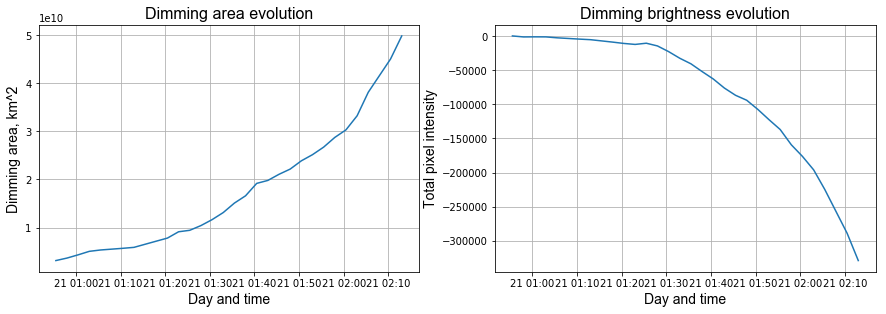

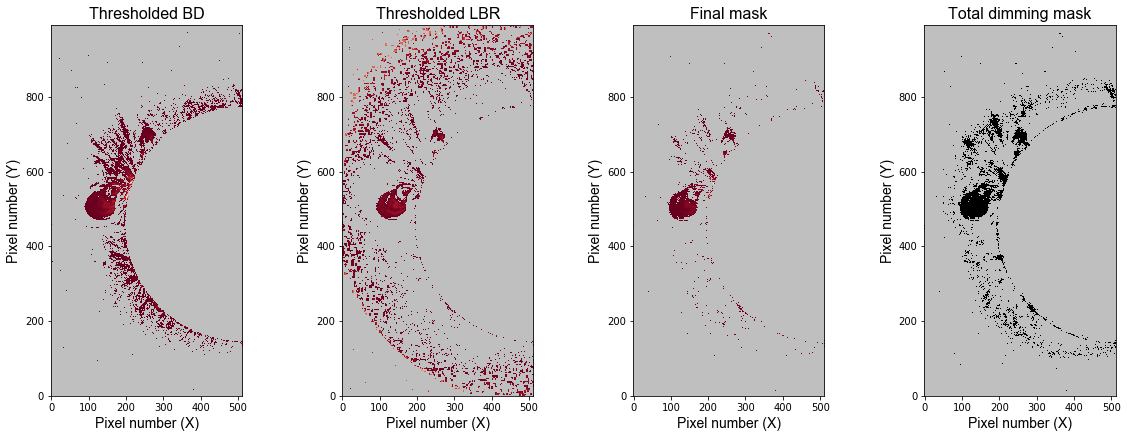

In [50]:
files_ = [sunpy.io.fits.read('Ass9_data/20110621_0052/20110621_0052_0%02d_195.fits' % i)[0] for i in range(31) if i != 8]
data_ = [files_[i].data for i in range(30)]
header_ = [files_[i].header for i in range(30)]

area2 = dim_analysis(data_, header_, 30)

#a_arr.append(area)

**For this event maps look correct, the curves for area and intensity are too smooth still they behave as expected. With setted levels of thresholding too much was filtered.**

**26 November 2011 event:**

/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in subtract


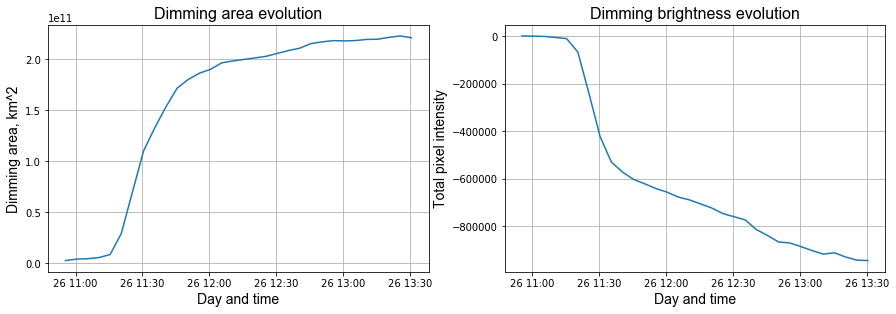

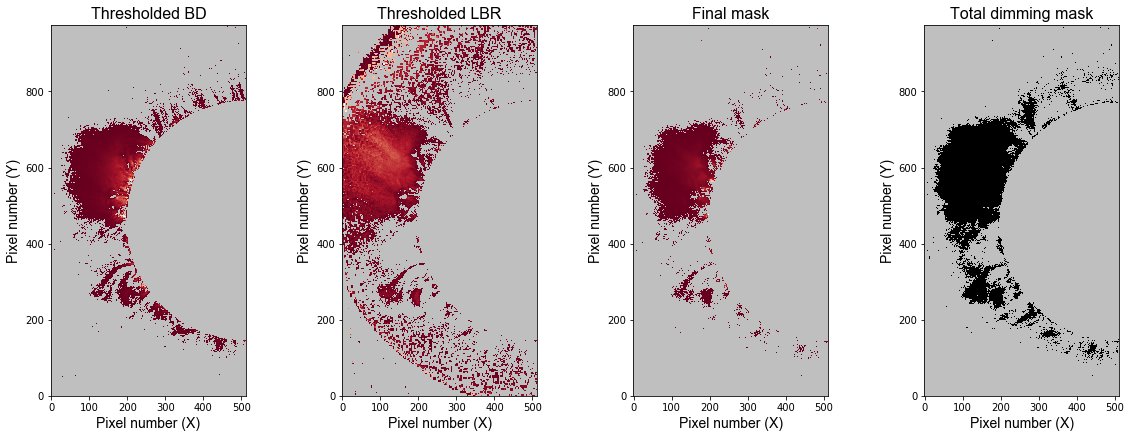

In [39]:
files_ = [sunpy.io.fits.read('Ass9_data/20111226_1046/20111226_1046_0%02d_195.fits' % i)[0] for i in range(31)]
data_ = [files_[i].data for i in range(31)]
header_ = [files_[i].header for i in range(31)]

area = dim_analysis(data_, header_, 31)
a_arr.append(area)

**Plots confirm the assumptions made during processing of the first event. Thresholding could be more strict but the extraction is acceptable.**

**19 January 2012 event:**

/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


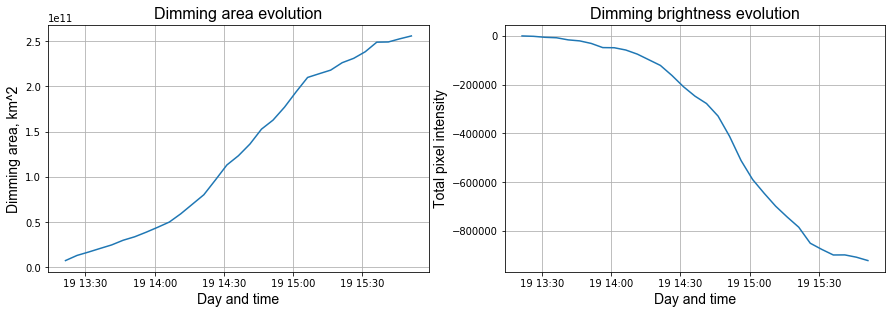

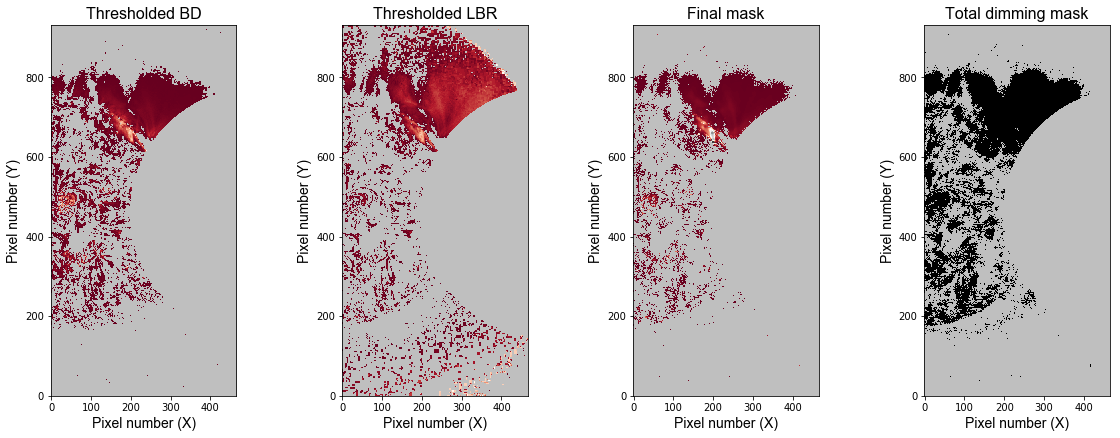

In [41]:
files_ = [sunpy.io.fits.read('Ass9_data/20120119_1314/20120119_1314_0%02d_195.fits' % i)[0] for i in range(31)]
data_ = [files_[i].data for i in range(31)]
header_ = [files_[i].header for i in range(31)]

area = dim_analysis(data_, header_, 31)
a_arr.append(area)

**Thresholding can be more severe (too many noise areas were remained), plots behave in a proper way.**

**6 March 2012 event:**

/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in subtract


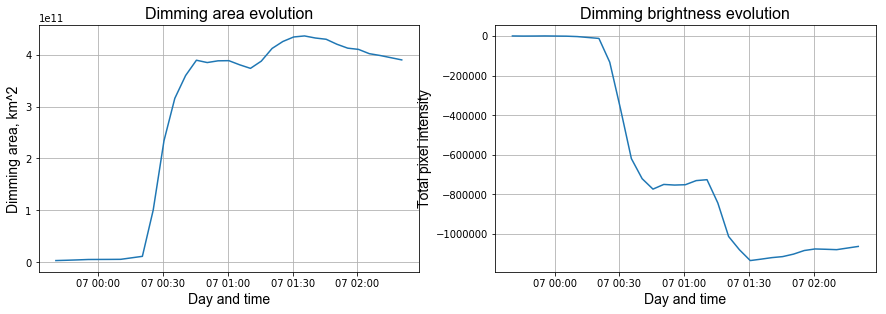

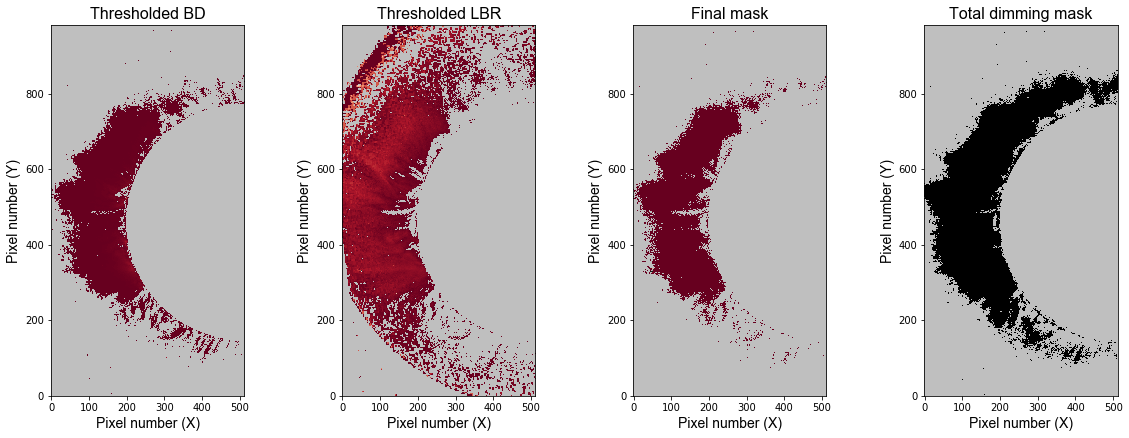

In [42]:
files_ = [sunpy.io.fits.read('Ass9_data/20120306_2332/20120306_2332_0%02d_195.fits' % i)[0] for i in range(31)]
data_ = [files_[i].data for i in range(31)]
header_ = [files_[i].header for i in range(31)]

area = dim_analysis(data_, header_, 31)
a_arr.append(area)

**14 March 2012 event:**

/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
/Users/polina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in subtract


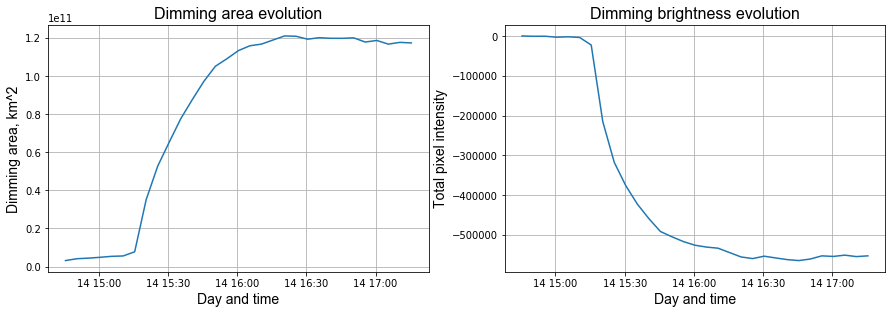

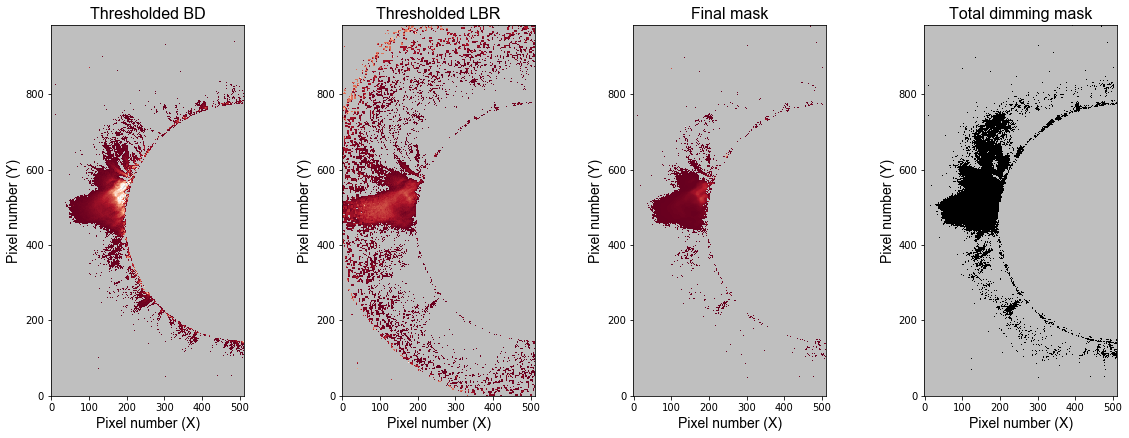

In [43]:
files_ = [sunpy.io.fits.read('Ass9_data/20120314_1438/20120314_1438_0%02d_195.fits' % i)[0] for i in range(31)]
data_ = [files_[i].data for i in range(31)]
header_ = [files_[i].header for i in range(31)]

area = dim_analysis(data_, header_, 31)
a_arr.append(area)

**It is a low-mass ejection and it is seen from maps.**

In [72]:
print('Total areas, km^2', round(a_arr[0]), round(area2), round(a_arr[1]), round(a_arr[2]), round(a_arr[3]), round(a_arr[4]))

Total areas, km^2 343973179517 115979670761 359930114084 440448835472 591756440097 230688304436


**Create the scatter plot of the dimming area against the mass of the CME:**

We decided to exclude the second event from consideration as the calculated area is too little for the value of mass ejected (1,1 * 10^11 km^2).

In [53]:
CME_masses = [6.69, 4.60, 13.55, 18.35, 3.41] # order corresponds to considered datasets, in 10^15 g

Text(0.5, 1.0, 'Dimming area against the mass of the CME')

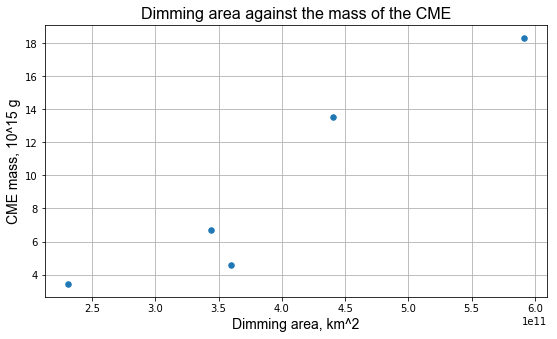

In [54]:
plt.figure(figsize=(9,5))
plt.scatter(a_arr, CME_masses, s=30)
plt.grid(True)
plt.xlabel('Dimming area, km^2', **axis_font)
plt.ylabel('CME mass, 10^15 g', **axis_font)
plt.title('Dimming area against the mass of the CME', **title_font)

**Let's make a linear fit to the data and overplot it:**

In [57]:
from sklearn.linear_model import LinearRegression

x = np.array(a_arr).reshape(-1, 1)
y = CME_masses
model = LinearRegression().fit(x, y)

intercept = model.intercept_
slope = model.coef_
a = slope
b = intercept
y_fit = a * a_arr + b

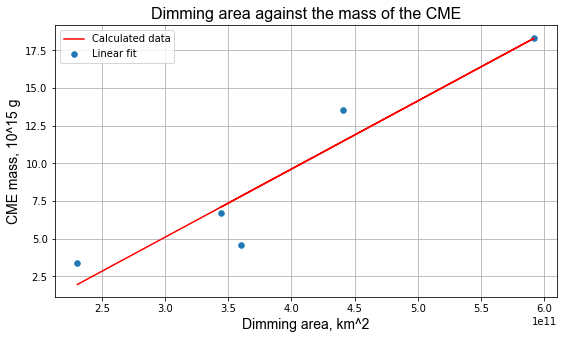

In [58]:
plt.figure(figsize=(9,5))
plt.scatter(a_arr, CME_masses, s=30)
plt.plot(a_arr, y_fit, color='red')
plt.grid(True)
plt.xlabel('Dimming area, km^2', **axis_font)
plt.ylabel('CME mass, 10^15 g', **axis_font)
plt.title('Dimming area against the mass of the CME', **title_font)
plt.legend(['Calculated data', 'Linear fit'])

**Finding the Pearson correlation coefficient:**

In [59]:
print('Pearson correlation coefficient between the dimming area and CME mass is {:.1f}'.format(scipy.stats.pearsonr(a_arr, CME_masses)[0]))

Pearson correlation coefficient between the dimming area and CME mass is 0.9


**Let's do the same for the data of CME speed:**

In [60]:
speed = [0.96, 1.02, 3.69] # 10^3 km/sec

In [62]:
areas = [a_arr[0], a_arr[1], a_arr[3]]

Text(0.5, 1.0, 'Dimming area against the speed of the CME')

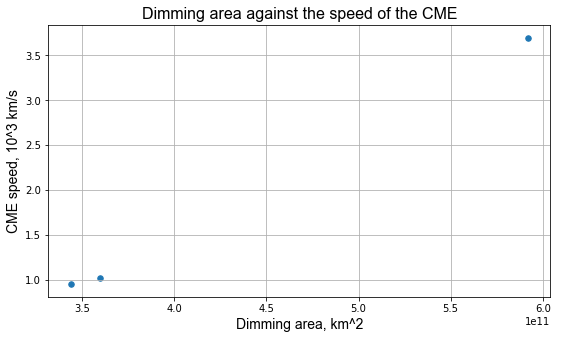

In [63]:
plt.figure(figsize=(9,5))
plt.scatter(areas, speed, s=30)
plt.grid(True)
plt.xlabel('Dimming area, km^2', **axis_font)
plt.ylabel('CME speed, 10^3 km/s', **axis_font)
plt.title('Dimming area against the speed of the CME', **title_font)

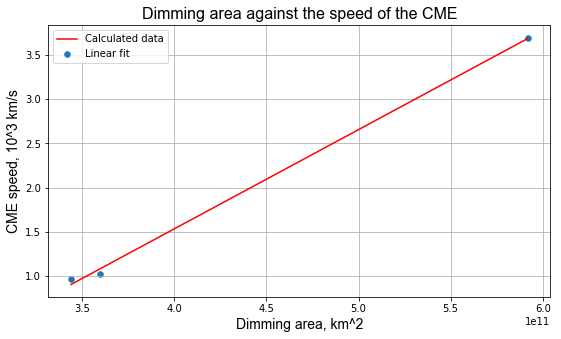

In [65]:
from sklearn.linear_model import LinearRegression

x = np.array(areas).reshape(-1, 1)
y = speed
model = LinearRegression().fit(x, y)

intercept = model.intercept_
slope = model.coef_
a = slope
b = intercept
y_fit = a * areas + b

plt.figure(figsize=(9,5))
plt.scatter(areas, speed, s=30)
plt.plot(areas, y_fit, color='red')
plt.grid(True)
plt.xlabel('Dimming area, km^2', **axis_font)
plt.ylabel('CME speed, 10^3 km/s', **axis_font)
plt.title('Dimming area against the speed of the CME', **title_font)
plt.legend(['Calculated data', 'Linear fit'])

In [66]:
print('Pearson correlation coefficient between the dimming area and CME speed is {:.1f}'.format(scipy.stats.pearsonr(areas, speed)[0]))

Pearson correlation coefficient between the dimming area and CME speed is 1.0


**From the scatterplots high correlation of CME speed/mass and total area of dimming can be derived. Pearson coefficients are large enough to make the same conslusion.**

**Discussion and learning log:**

Dimmings are important to study as it is one of the most distict signatures of coronal mass ejections – huge clouds of magnetized plasma that are expelled from the Sun to interplanetary space with high speeds. After CME departure from the Sun there's a void space with low intensity of emission (mostly in soft X-ray and EUV).  

CME is a significant driver of space weather effects (electronics disruption, high radiation in Earth atmosphere and related disturbances). Properties (mass, speed) of CME are difficult to measure directly as there's problems with projection effects and little capability to catch early evolution as well. However, studying associated with CME phenomena can help with estimation of CME's parameters even in the case of the absence of coronographs.
  
Thresholding is meant to extract the lowest intensity areas, so it should be big enough (absolute value), to skip the average emission in corona.

From scatterplots and correlation coefficients we can derive the distint direct relation between CME properties and total area of a dimmimg.